#### references
- https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8  
    - pokemon data를 이용한 EDA

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.metrics import (
    accuracy_score, f1_score , 
    precision_score, recall_score,
    mean_squared_error,
    
    confusion_matrix
)

# load data (with drop_duplicates)

In [2]:
data = pd.read_csv("./archive/Complete Pokedex V1.1.csv").drop_duplicates()
### check duplicates
print(len(data.drop_duplicates(subset=['pokemon_name'])) == len(data))
print(data.shape)

True
(1118, 63)


In [3]:
data.head(3)

,pokedex_number,pokemon_name,type_1,type_2,ability_1,ability_2,ability_3,number_pokemon_with_typing,primary_color,shape,height,weight,bmi,hit_points,attack,defense,special_attack,special_defense,speed,total_stats,mean,standard_deviation,capture_rate,generation,base_happiness,base_experience,exp_type,exp_to_level_100,can_evolve,evolves_from,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,legendary,mythical,genderless,female_rate,genus,egg_group_1,egg_group_2,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,1,Bulbasaur,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,0.7,6.9,14.1,45,49,49,65,65,45,318,53.00,8.64,45,1,70,64,Medium Slow,1059860,True,NaN,False,False,True,False,False,False,False,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,2,Ivysaur,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,1.0,13.0,13.0,60,62,63,80,80,60,405,67.50,8.90,45,1,70,142,Medium Slow,1059860,True,Bulbasaur,False,False,True,False,False,False,False,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,3,Mega Venusaur,Grass,Poison,Thick Fat,NaN,NaN,15,Green,Quadruped,2.4,155.5,27.0,80,100,123,122,120,80,625,104.17,18.75,45,6,70,281,Medium Slow,1059860,False,Ivysaur,True,True,False,False,False,False,True,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5


## handling outliers on 'weight' column

In [4]:
# Remove outliers by setting values outside of (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR) to NaN
# data['super_heavy'] = np.where(data['weight']==10000, True, False)
super_heavy = data[data['weight']==10000]
data['weight'] = np.where(data['weight']==10000, np.nan, data['weight'])
data = data.dropna(subset=['weight']).reset_index(drop=True)

In [5]:
print(data.shape)
print(super_heavy.shape)  # removed !

(1083, 63)
(35, 63)


#### 'gmax' in name -> weight 10000

In [6]:
super_heavy.head(10)

,pokedex_number,pokemon_name,type_1,type_2,ability_1,ability_2,ability_3,number_pokemon_with_typing,primary_color,shape,height,weight,bmi,hit_points,attack,defense,special_attack,special_defense,speed,total_stats,mean,standard_deviation,capture_rate,generation,base_happiness,base_experience,exp_type,exp_to_level_100,can_evolve,evolves_from,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,legendary,mythical,genderless,female_rate,genus,egg_group_1,egg_group_2,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
4,3,Venusaur Gmax,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,24.0,10000.0,17.4,80,82,83,100,100,80,525,87.50,8.90,45,8,70,236,Medium Slow,1059860,False,Ivysaur,False,False,False,False,False,False,True,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.00,0.50,1.00,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
8,6,Charizard Gmax,Fire,Flying,Blaze,Solar Power,NaN,7,Red,Upright,28.0,10000.0,12.8,78,84,78,109,85,100,534,89.00,11.58,45,8,70,240,Medium Slow,1059860,False,Charmeleon,False,False,False,False,False,False,True,False,False,False,0.125,Flame,Monster,Dragon,20,1.0,0.5,2.0,2.0,0.25,1.00,0.50,1.00,0.0,1.0,1.0,0.25,4.0,1.0,1.0,1.0,0.5,0.5
14,9,Blastoise Gmax,Water,NaN,Torrent,Rain Dish,NaN,72,Blue,Upright,25.0,10000.0,16.0,79,83,100,85,105,78,530,88.33,10.39,45,8,70,239,Medium Slow,1059860,False,Wartortle,False,False,False,False,False,False,True,False,False,False,0.125,Shellfish,Monster,Water 1,20,1.0,0.5,0.5,2.0,2.00,0.50,1.00,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
19,12,Butterfree Gmax,Bug,Flying,Compound Eyes,Tinted Lens,NaN,14,White,Bug-Wings,17.0,10000.0,34.6,60,45,50,90,80,70,395,65.83,15.92,45,8,70,178,Medium Fast,1000000,False,Metapod,False,False,False,False,False,False,False,False,False,False,0.500,Butterfly,Bug,NaN,15,1.0,2.0,1.0,2.0,0.25,2.00,0.25,1.00,0.0,2.0,1.0,0.50,4.0,1.0,1.0,1.0,1.0,1.0
41,25,Pikachu Gmax,Electric,NaN,Static,Lightning Rod,NaN,34,Yellow,Quadruped,21.0,10000.0,22.7,35,55,40,50,50,90,320,53.33,17.72,190,8,70,112,Medium Fast,1000000,True,Pichu,False,False,False,False,False,False,False,False,False,False,0.500,Mouse,Field,Fairy,10,1.0,1.0,1.0,0.5,1.00,1.00,1.00,1.00,2.0,0.5,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
88,52,Meowth Gmax,Normal,NaN,Pickup,Technician,Unnerve,71,Yellow,Quadruped,33.0,10000.0,9.2,40,45,35,40,40,90,290,48.33,18.86,255,8,70,58,Medium Fast,1000000,True,NaN,False,False,False,False,False,False,False,False,False,False,0.500,Scratch Cat,Field,NaN,20,1.0,1.0,1.0,1.0,1.00,1.00,2.00,1.00,1.0,1.0,1.0,1.00,1.0,0.0,1.0,1.0,1.0,1.0
107,68,Machamp Gmax,Fighting,NaN,Guts,No Guard,Steadfast,29,Gray,Humanoid,25.0,10000.0,16.0,90,130,80,65,85,55,505,84.17,23.70,45,8,70,227,Medium Slow,1059860,False,Machoke,False,False,False,False,False,False,False,False,False,False,0.250,Superpower,Human-Like,NaN,20,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.0,2.0,2.0,0.50,0.5,1.0,1.0,0.5,1.0,2.0
145,94,Gengar Gmax,Ghost,Poison,Cursed Body,NaN,NaN,4,Purple,Upright,2.0,10000.0,2500.0,60,65,60,130,75,110,500,83.33,27.03,45,8,70,225,Medium Slow,1059860,False,Haunter,False,False,False,False,False,False,True,False,False,False,0.500,Shadow,Amorphous,NaN,20,0.0,1.0,1.0,1.0,0.50,1.00,0.00,0.25,2.0,1.0,2.0,0.25,1.0,2.0,1.0,2.0,1.0,0.5
152,99,Kingler Gmax,Water,NaN,Hyper Cutter,Shell Armor,Sheer Force,72,Red,Armor,19.0,10000.0,27.7,55,130,115,50,50,75,475,79.17,32.07,60,8,70,166,Medium Fast,1000000,False,Krabby,False,False,False,False,False,False,False,False,False,False,0.500,Pincer,Water 3,NaN,20,1.0,0.5,0.5,2.0,2.00,0.50,1.00,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
193,131,Lapras Gmax,Water,Ice,Water Absorb,Shell Armor,Hydration,7,Blue,Fish,24.0,10000.0,17.4,130,85,80,85,95,60,535,89.17,21.10,45,8,70,187,Slow,1250000,False,Na

# EDA

## check columns

In [7]:
print(len(data.columns))
data.columns

63


Index(['pokedex_number', 'pokemon_name', 'type_1', 'type_2', 'ability_1',
       'ability_2', 'ability_3', 'number_pokemon_with_typing', 'primary_color',
       'shape', 'height', 'weight', 'bmi', 'hit_points', 'attack', 'defense',
       'special_attack', 'special_defense', 'speed', 'total_stats', 'mean',
       'standard_deviation', 'capture_rate', 'generation', 'base_happiness',
       'base_experience', 'exp_type', 'exp_to_level_100', 'can_evolve',
       'evolves_from', 'final_evolution', 'mega_evolution', 'is_default',
       'baby_pokemon', 'alolan_form', 'galarian_form', 'forms_switchable',
       'legendary', 'mythical', 'genderless', 'female_rate', 'genus',
       'egg_group_1', 'egg_group_2', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fighting', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', '

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pokedex_number              1083 non-null   int64  
 1   pokemon_name                1083 non-null   object 
 2   type_1                      1083 non-null   object 
 3   type_2                      577 non-null    object 
 4   ability_1                   1083 non-null   object 
 5   ability_2                   831 non-null    object 
 6   ability_3                   518 non-null    object 
 7   number_pokemon_with_typing  1083 non-null   int64  
 8   primary_color               1083 non-null   object 
 9   shape                       1083 non-null   object 
 10  height                      1083 non-null   float64
 11  weight                      1083 non-null   float64
 12  bmi                         1083 non-null   float64
 13  hit_points                  1083 

## null data

In [9]:
null = data.isnull().sum()
null = null[null>=1]
null_columns = null.index
print(f"null values contained : {null_columns}")
null

null values contained : Index(['type_2', 'ability_2', 'ability_3', 'evolves_from', 'egg_group_2'], dtype='object')


type_2          506
ability_2       252
ability_3       565
evolves_from    563
egg_group_2     780
dtype: int64

#### check null data

In [10]:
for col in null_columns:
    print(f" # === {col} === ")
    print(f"{data[col].head(2)}\n")

 # === type_2 === 
0    Poison
1    Poison
Name: type_2, dtype: object

 # === ability_2 === 
0    Chlorophyll
1    Chlorophyll
Name: ability_2, dtype: object

 # === ability_3 === 
0    NaN
1    NaN
Name: ability_3, dtype: object

 # === evolves_from === 
0          NaN
1    Bulbasaur
Name: evolves_from, dtype: object

 # === egg_group_2 === 
0    Grass
1    Grass
Name: egg_group_2, dtype: object



## split data into 8-generation dataset

In [11]:
print(sorted(data['generation'].unique()))
gens = [ data[data['generation']==(idx+1)] for idx in range(8) ]
print([len(gens[idx]) for idx in range(8)], ": size of data for each generation")

[1, 2, 3, 4, 5, 6, 7, 8]
[151, 100, 138, 118, 165, 141, 149, 121] : size of data for each generation


# 1-1) relationships among ['height', 'weight', 'hit_points', 'attack', 'defense']

In [12]:
cols = ['height', 'weight', 'hit_points', 'attack', 'defense']

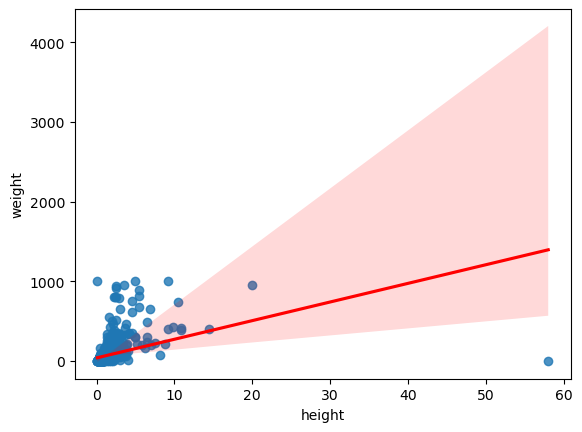

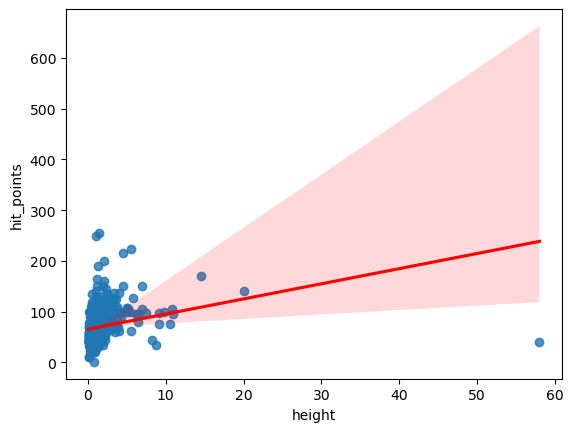

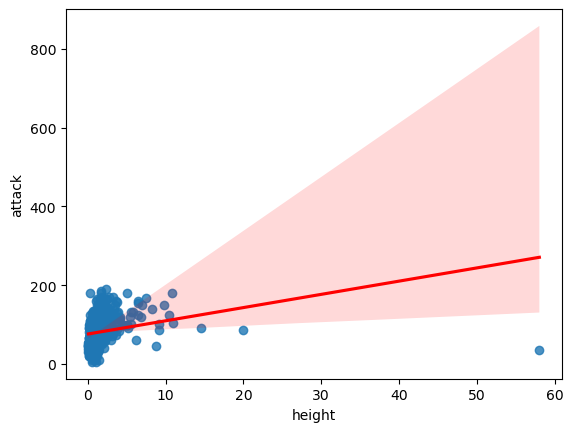

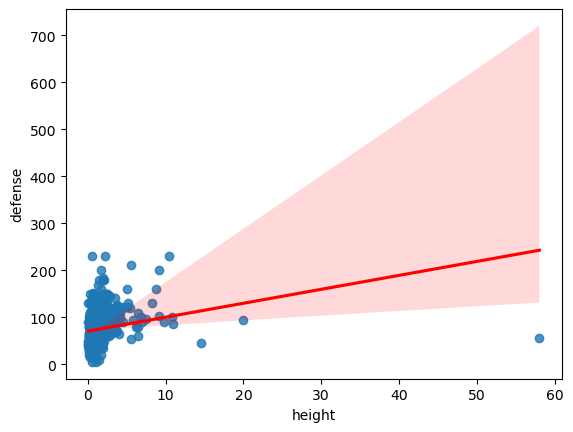

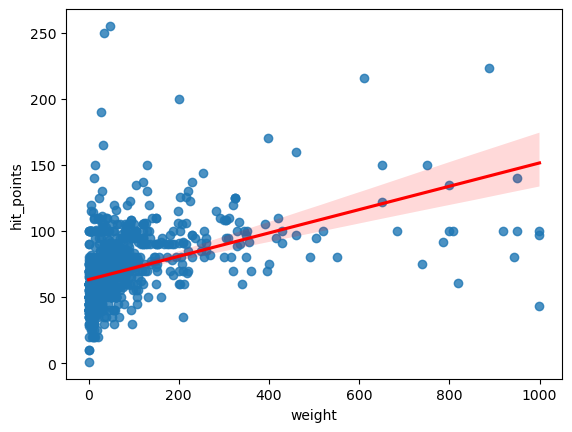

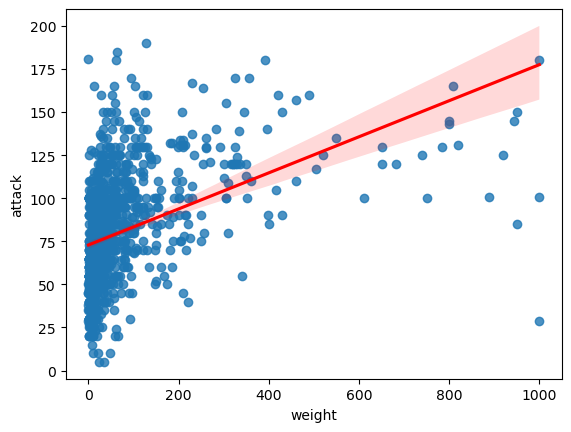

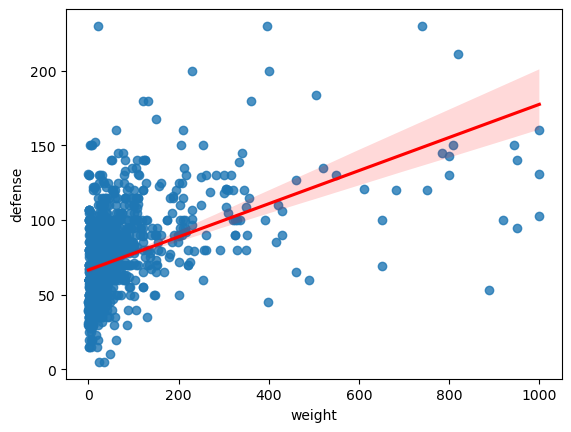

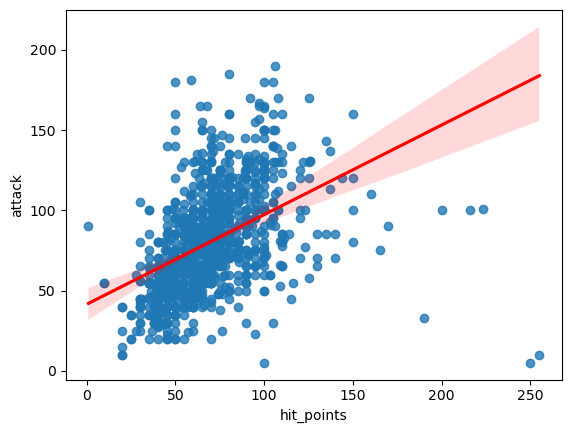

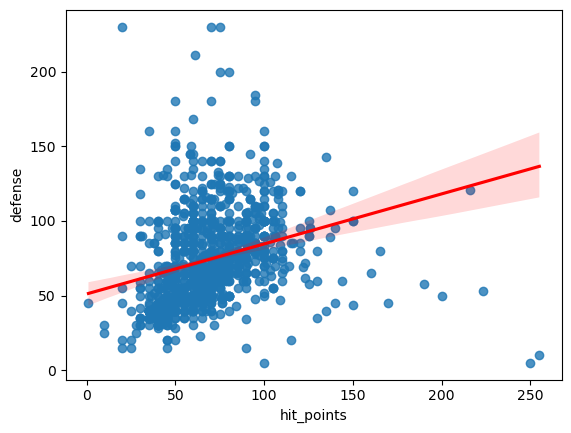

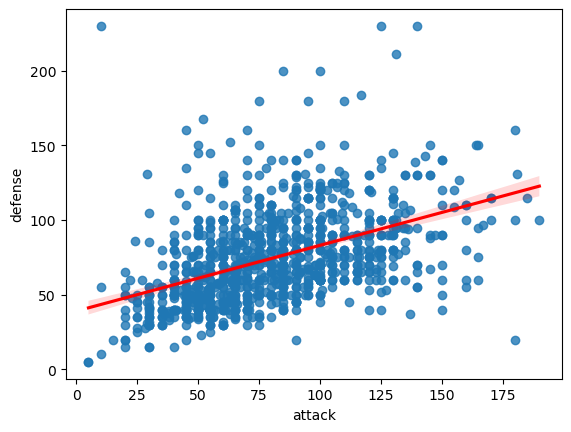

In [13]:
for idx1 in range(len(cols)):
    for idx2 in range(idx1+1, len(cols)):
        sns.regplot(x=cols[idx1], y=cols[idx2], data=data, line_kws={'color':'red'})
        plt.show()

<AxesSubplot:>

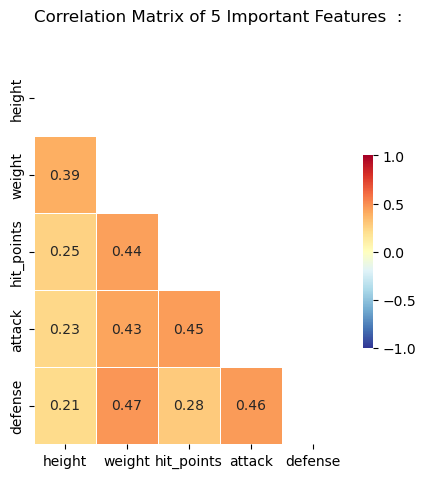

In [14]:
fig, axes = plt.subplots(figsize = (5,5))
fig.suptitle('Correlation Matrix of 5 Important Features  : ')

corrs = data[['height', 'weight', 'hit_points', 'attack', 'defense']].corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    data=corrs,
    annot=True,
    mask=mask,
    linewidths=.5,
    cmap = 'RdYlBu_r',
    cbar_kws={"shrink":.5},
    vmin = -1, vmax = 1,
)

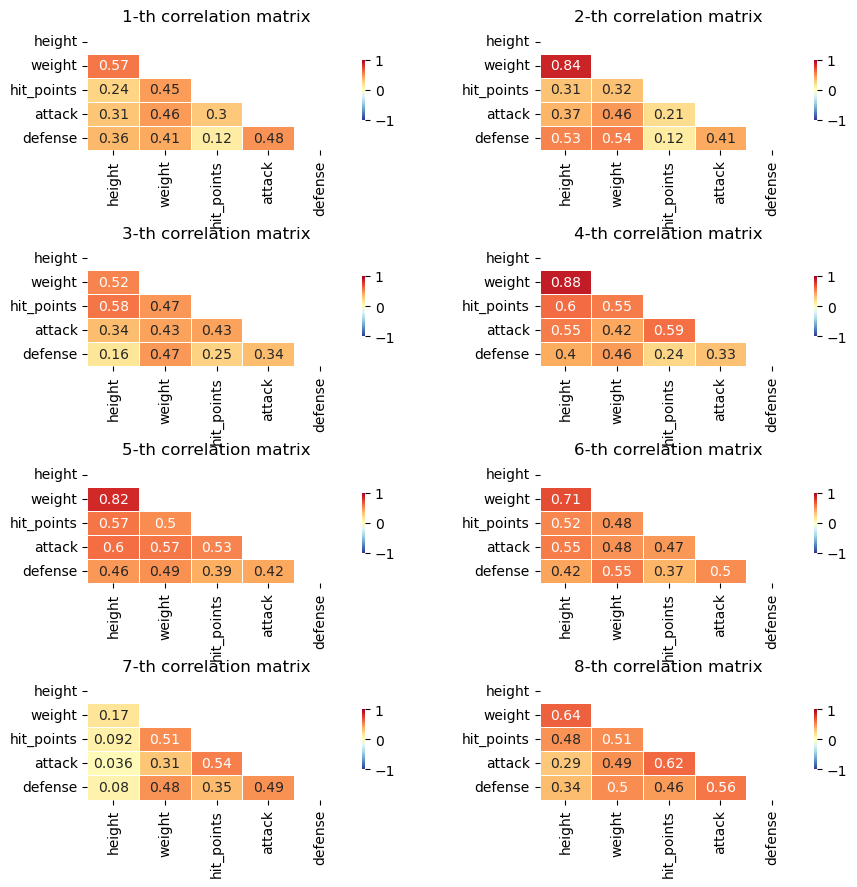

In [15]:
"""
reference
- https://m.blog.naver.com/kiddwannabe/221763497317
"""

Y = 4
X = 2
fig.suptitle('Correlation Matrix of 5 Important Features  : ')
fig, axes = plt.subplots(Y, X, figsize = (10,10))
plt.subplots_adjust(wspace=0.4, hspace = 0.8)

corrs = [gens[idx][['height', 'weight', 'hit_points', 'attack', 'defense']].corr() for idx in range(8)]
mask = np.zeros_like(corrs[0])
mask[np.triu_indices_from(mask)] = True

for y in range(Y):
    for x in range(X):        
        axes[y,x].set_title(f"{y*X + x + 1}-th correlation matrix")
        sns.heatmap(
            ax = axes[y,x],
            data=corrs[y*X + x],
            annot=True,
            mask=mask,
            linewidths=.5,
            cmap = 'RdYlBu_r',
            cbar_kws={"shrink":.5},
            vmin = -1, vmax = 1,
        )
plt.show()


# 1-2) How to these relationships evolve over generations of Pokemon

<AxesSubplot:xlabel='generation', ylabel='weight'>

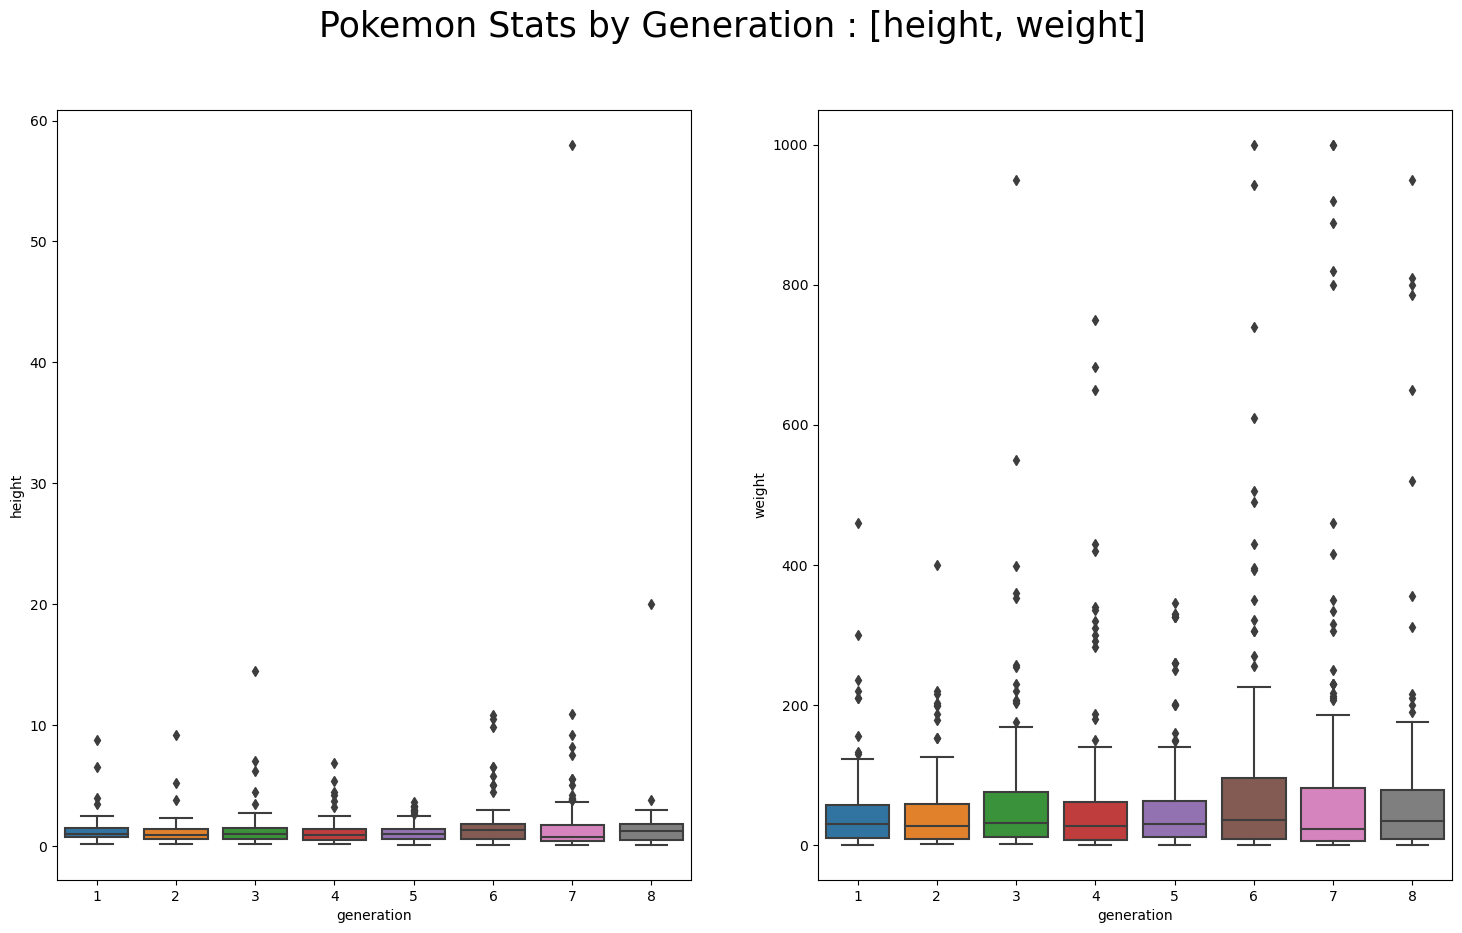

In [16]:
fig, axes = plt.subplots(1,2, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation : [height, weight]', size=25)
sns.boxplot(ax=axes[0], data=data, x='generation', y='height')
sns.boxplot(ax=axes[1], data=data, x='generation', y='weight')

In [17]:
# import copy

# del_outliers = copy.deepcopy(data)

# h = del_outliers['height'] 
# h_1q = h.quantile(0.25)
# h_3q = h.quantile(0.75)
# h_IQR = h_3q-h_1q
# rev_range = 1.5

# w = del_outliers['weight'] 
# w_1q = w.quantile(0.25)
# w_3q = w.quantile(0.75)
# w_IQR = w_3q-w_1q
# rev_range = 1.5

# del_outliers['height'] = (del_outliers[ h<= h_3q+(rev_range*h_IQR))  ]

<AxesSubplot:xlabel='generation', ylabel='speed'>

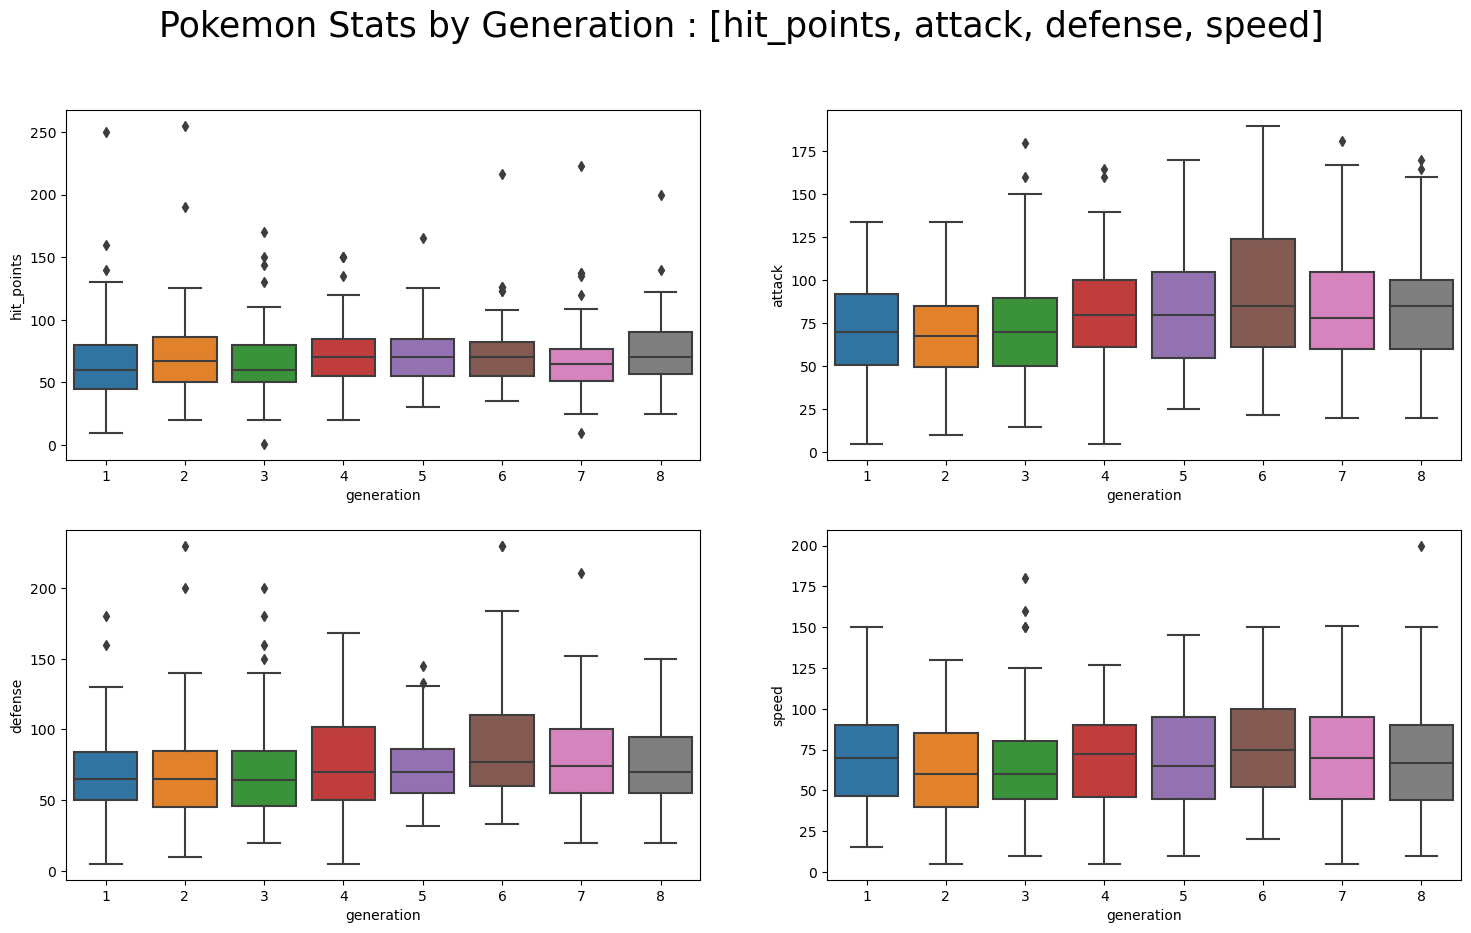

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Pokemon Stats by Generation : [hit_points, attack, defense, speed]', size= 25)
sns.boxplot(ax=axes[0, 0], data=data, x='generation', y='hit_points')
sns.boxplot(ax=axes[0, 1], data=data, x='generation', y='attack')
sns.boxplot(ax=axes[1, 0], data=data, x='generation', y='defense')
sns.boxplot(ax=axes[1, 1], data=data, x='generation', y='speed')


# 1-3) Which attributes significantly explain why certain Pokemon characters are classified as legendary or mythical?

In [19]:
data.columns

Index(['pokedex_number', 'pokemon_name', 'type_1', 'type_2', 'ability_1',
       'ability_2', 'ability_3', 'number_pokemon_with_typing', 'primary_color',
       'shape', 'height', 'weight', 'bmi', 'hit_points', 'attack', 'defense',
       'special_attack', 'special_defense', 'speed', 'total_stats', 'mean',
       'standard_deviation', 'capture_rate', 'generation', 'base_happiness',
       'base_experience', 'exp_type', 'exp_to_level_100', 'can_evolve',
       'evolves_from', 'final_evolution', 'mega_evolution', 'is_default',
       'baby_pokemon', 'alolan_form', 'galarian_form', 'forms_switchable',
       'legendary', 'mythical', 'genderless', 'female_rate', 'genus',
       'egg_group_1', 'egg_group_2', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fighting', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', '

## set feature / target columns 

In [20]:
# usesless columns
names = [
    'pokedex_number', 
    'pokemon_name', 
    'number_pokemon_with_typing', 
    'evolves_from',
    'base_experience',
    'exp_to_level_100',
]
redundant = [
    'bmi', 
    'total_stats', 
    'mean', 
    'standard_deviation',
    'genderless',
]
useless = names + redundant


# Y : targets
target_columns = [
    'legendary',
    'mythical',
]

# X : features
categorical = []
continuous  = []


In [21]:
for col in data.columns:
    if col in useless:
        continue
    if col in target_columns:
        continue
        
    if (data[col].dtype in [np.int64, np.float64]):
        if len(data[col].unique()) < 3: 
            categorical.append(col)
        else:
            continuous.append(col)
    elif (data[col].dtype in['object', 'bool']) | (col == 'exp_to_level_100'):
        categorical.append(col)

In [22]:
len(data.columns) == len(useless) + len(target_columns)+len(categorical) + len(continuous)

True

In [23]:
continuous

['height',
 'weight',
 'hit_points',
 'attack',
 'defense',
 'special_attack',
 'special_defense',
 'speed',
 'capture_rate',
 'generation',
 'base_happiness',
 'female_rate',
 'egg_cycles',
 'against_normal',
 'against_fire',
 'against_water',
 'against_electric',
 'against_grass',
 'against_ice',
 'against_fighting',
 'against_poison',
 'against_ground',
 'against_flying',
 'against_psychic',
 'against_bug',
 'against_rock',
 'against_ghost',
 'against_dragon',
 'against_dark',
 'against_steel',
 'against_fairy']

In [24]:
categorical

['type_1',
 'type_2',
 'ability_1',
 'ability_2',
 'ability_3',
 'primary_color',
 'shape',
 'exp_type',
 'can_evolve',
 'final_evolution',
 'mega_evolution',
 'is_default',
 'baby_pokemon',
 'alolan_form',
 'galarian_form',
 'forms_switchable',
 'genus',
 'egg_group_1',
 'egg_group_2']

In [25]:
X = data[continuous+categorical].fillna('')
Y = np.where(data[target_columns].T.sum() >= 1, 1, 0) # either 'lenendary' or 'mythycal' or both

In [26]:
split_point = int(len(X)*0.7)
X_train, X_test = X[:split_point-1], X[split_point:]
Y_train, Y_test = Y[:split_point-1], Y[split_point:]

In [27]:
# label encoding for categorical variables

encoders = []

# for train
for idx in range(len(categorical)):
    encoder = LabelEncoder()
    X_train[categorical[idx]] = encoder.fit_transform(X_train[categorical[idx]])
    encoders.append(encoder)

# for test
for idx in range(len(categorical)):
    for label in np.unique(X_test[categorical[idx]]):
        if label not in encoders[idx].classes_: # handling unseen labels 
            encoders[idx].classes_ = np.append(encoders[idx].classes_, label) # to prevent ValueError from appearing
    X_test[categorical[idx]] = encoders[idx].transform(X_test[categorical[idx]])


In [28]:
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

757 757 325 325


# Classifier

#### SVM Classifier

In [29]:
SVM_model = SVC()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
SVM_param_grid = [
    {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : [1,2,3,4]
    }
]
SVM_grid_search = GridSearchCV(
    estimator=SVM_model,
    param_grid=SVM_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

SVM_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'degree': [1, 2, 3, 4],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             verbose=2)

In [30]:
print(SVM_grid_search.best_params_)
print(SVM_grid_search.best_score_)
top_10_features = pd.DataFrame(SVM_grid_search.best_estimator_.coef_, columns = continuous + categorical).T.sort_values(0, ascending=False)[:10]
top_10_features.columns = ['importance']
top_10_features

{'C': 0.001, 'degree': 1, 'kernel': 'linear'}
0.996031746031746


,importance
egg_cycles,0.032983
egg_group_1,0.018501
defense,0.014083
hit_points,0.009655
shape,0.009620
speed,0.008728
special_attack,0.008054
type_1,0.007128
egg_group_2,0.004435
special_defense,0.003480


#### RandomForest Classifier

In [31]:
RF_model = RandomForestClassifier()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
RF_param_grid = [
    {
        'n_estimators' : [10, 50, 100, 150, 200],
        'max_depth' : [1,2,3,4],
    }
]
RF_grid_search = GridSearchCV(
    estimator=RF_model,
    param_grid=RF_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

RF_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4],
                          'n_estimators': [10, 50, 100, 150, 200]}],
             verbose=2)

In [32]:
print(RF_grid_search.best_params_)
print(RF_grid_search.best_score_)
top_10_features = pd.DataFrame(RF_grid_search.best_estimator_.feature_importances_.reshape(1, -1), columns = continuous + categorical).T.sort_values(0, ascending=False)[:10]
top_10_features.columns = ['importance']
top_10_features

{'max_depth': 3, 'n_estimators': 50}
0.9973544973544973


,importance
capture_rate,0.223852
egg_cycles,0.171111
female_rate,0.105084
base_happiness,0.096496
egg_group_1,0.085646
exp_type,0.055886
ability_2,0.035525
weight,0.031583
special_attack,0.027839
special_defense,0.026467


In [33]:
RF_grid_search.best_estimator_.feature_importances_.reshape(1, -1)

array([[8.60449375e-03, 3.15825737e-02, 2.39867412e-02, 1.36086313e-03,
        1.88323070e-02, 2.78389565e-02, 2.64671561e-02, 2.09868352e-02,
        2.23851507e-01, 2.19981881e-03, 9.64958551e-02, 1.05083675e-01,
        1.71110754e-01, 4.59972339e-04, 1.58670949e-03, 0.00000000e+00,
        0.00000000e+00, 1.81355452e-03, 1.14096337e-03, 4.96317019e-04,
        1.24705388e-03, 0.00000000e+00, 4.02054323e-03, 0.00000000e+00,
        2.60095377e-03, 2.85887169e-04, 0.00000000e+00, 3.52195958e-03,
        2.40095033e-03, 1.03600209e-04, 0.00000000e+00, 0.00000000e+00,
        8.79923220e-04, 2.12476218e-03, 3.55250002e-02, 1.66652596e-02,
        8.01193687e-04, 9.54230840e-03, 5.58857262e-02, 6.38213462e-03,
        4.98170664e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.77323132e-04, 8.04506084e-04,
        8.56459453e-02, 2.30420921e-03]])

#### Logistic Classifier

In [34]:
LR_model = LogisticRegression()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
LR_param_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C' : [0.01, 0.1, 1, 10, 100],
        'solver' : ['lbfgs', 'liblinear', 'newton=cg', 'saga']
    }
]
LR_grid_search = GridSearchCV(
    estimator=LR_model,
    param_grid=LR_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

LR_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 60 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['lbfgs', 'liblinear', 'newton=cg',
                                     'saga']}],
             verbose=2)

In [35]:
print(LR_grid_search.best_params_)
print(LR_grid_search.best_score_)
top_10_features = pd.DataFrame(LR_grid_search.best_estimator_.coef_, columns = continuous + categorical).T.sort_values(0, ascending=False)[:10]
top_10_features.columns = ['importance']
top_10_features

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.996031746031746


,importance
egg_group_1,0.681748
against_electric,0.494265
egg_cycles,0.208820
exp_type,0.137772
shape,0.106073
base_happiness,0.082504
egg_group_2,0.040120
hit_points,0.023927
special_attack,0.019497
speed,0.012358
